In [1]:
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import utils
import pandas as pd
from matplotlib.colors import ListedColormap


#plot parameters that I personally like, feel free to make these your own.
import matplotlib
import matplotlib.patheffects as path_effects

#outlines for text 
pe1 = [path_effects.withStroke(linewidth=1.5,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=1.5,
                             foreground="w")]

matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sys
sys.path.insert(1, '/projects/reba1583/Research3/WAF_ML_Tutorial_Part2/scripts/')
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod
from gewitter_functions import get_acc
from sklearn import metrics

2024-10-14 12:51:36.745553: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [39]:
name = '27'
fp = '/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/CNN_retry_2V/Test_Results/'
results = pd.read_csv(fp+'test'+name+'_preds.csv', index_col = 0)
val = pd.read_csv(fp+'test'+name+'_val.csv', index_col = 0)
history = pd.read_csv(fp+'test'+name+'_history.csv')


In [40]:
precision, recall, thresholds = metrics.precision_recall_curve(np.array(val).ravel(),np.array(results).ravel(), pos_label = 1)
auc_pr = np.round(metrics.auc(recall, precision),3)
print('AUC_PR: ')
auc_pr

AUC_PR: 


0.868

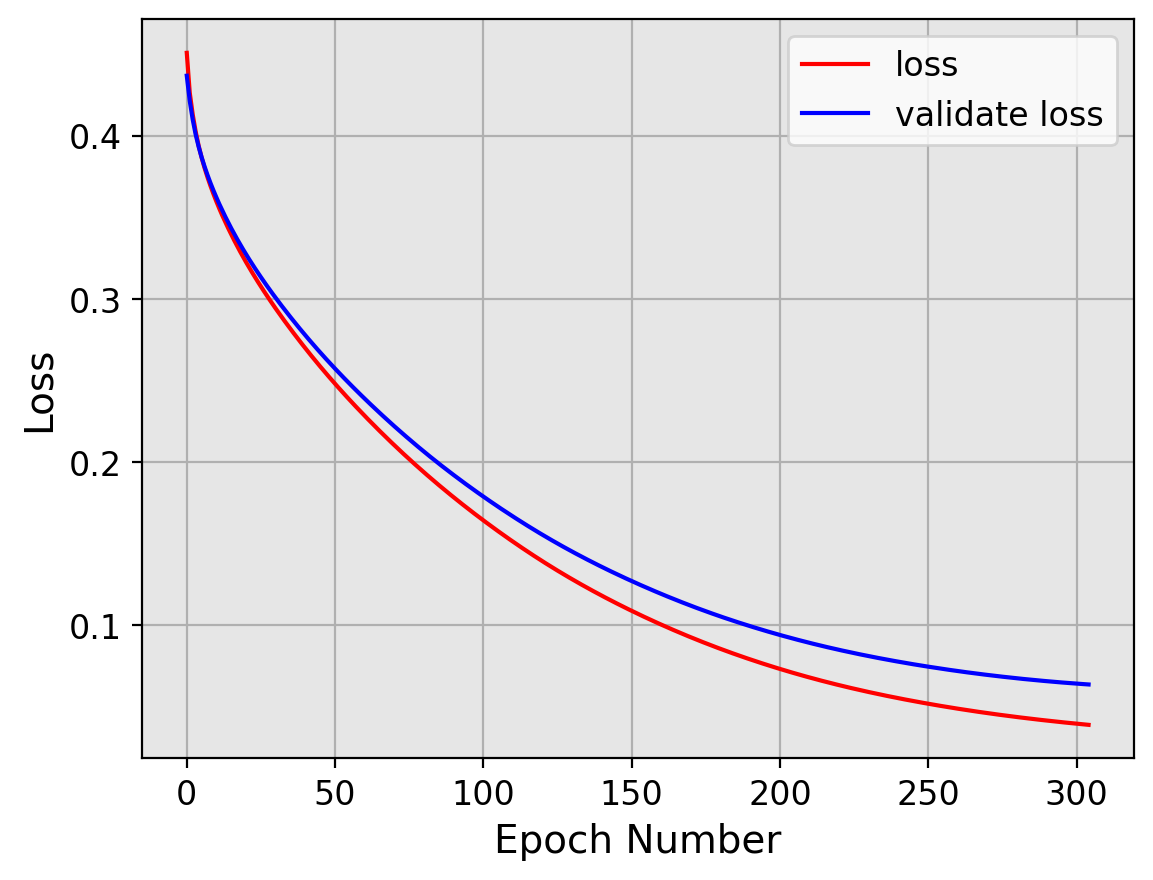

In [41]:
plt.plot(history['loss'],'-r', label = 'loss')
plt.plot(history['val_loss'],'-b', label = 'validate loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid()

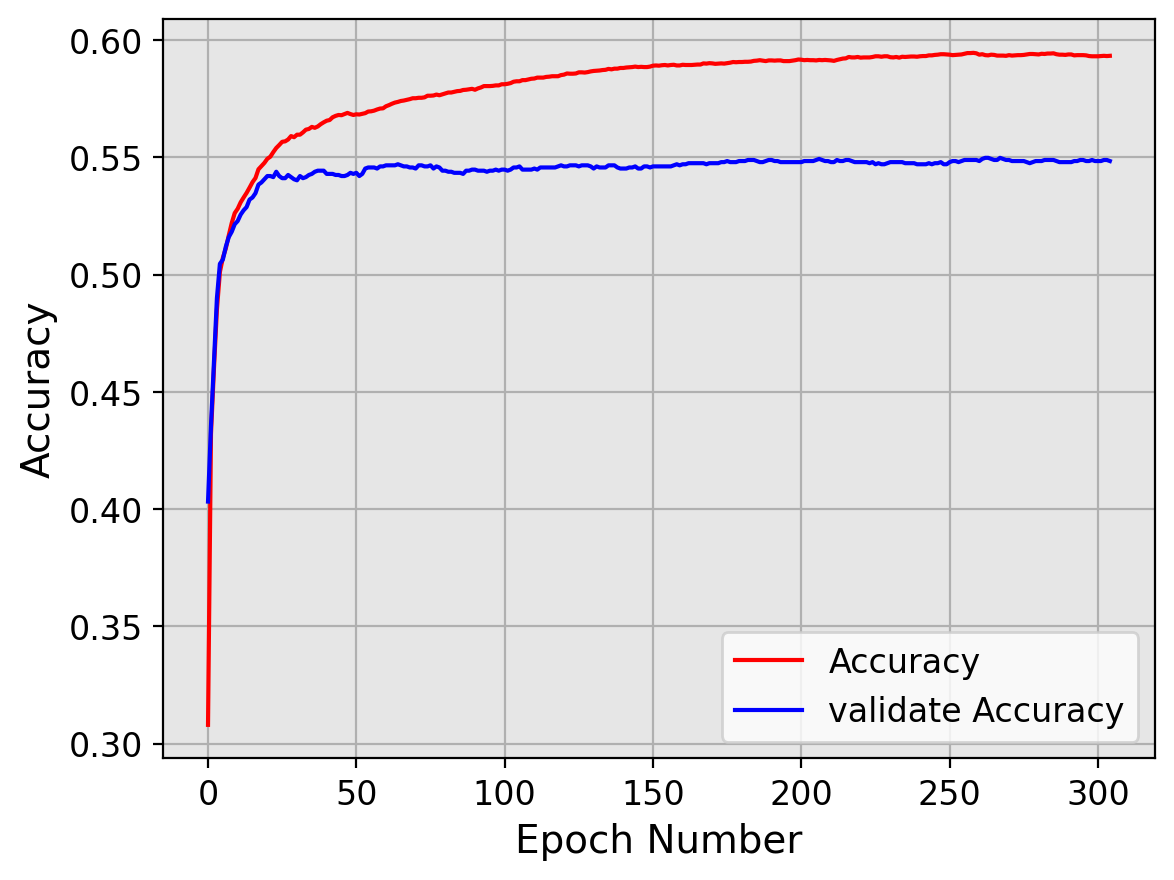

In [42]:
plt.plot(history['accuracy'],'-r', label = 'Accuracy')
plt.plot(history['val_accuracy'],'-b', label = 'validate Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

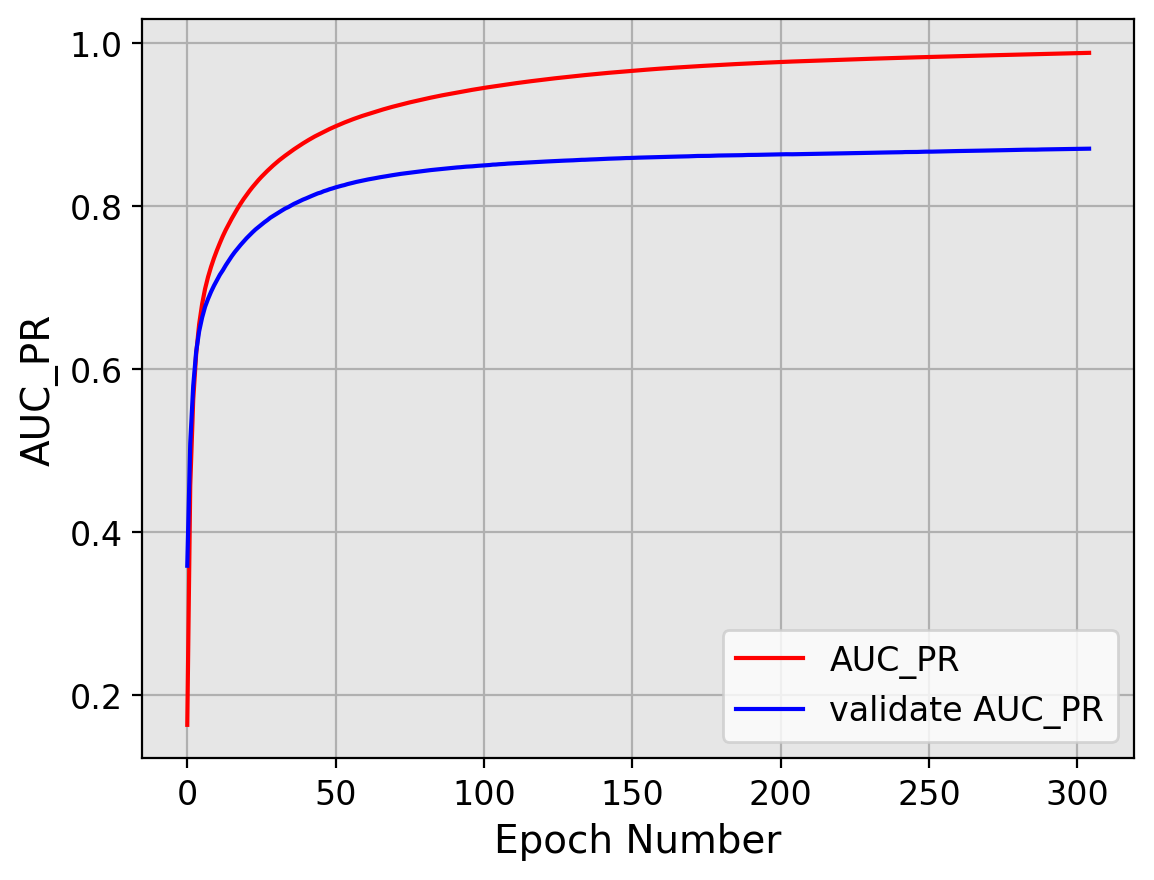

In [43]:
plt.plot(history['auc'],'-r', label = 'AUC_PR')
plt.plot(history['val_auc'],'-b', label = 'validate AUC_PR')
plt.xlabel('Epoch Number')
plt.ylabel('AUC_PR')
plt.legend()
plt.grid()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


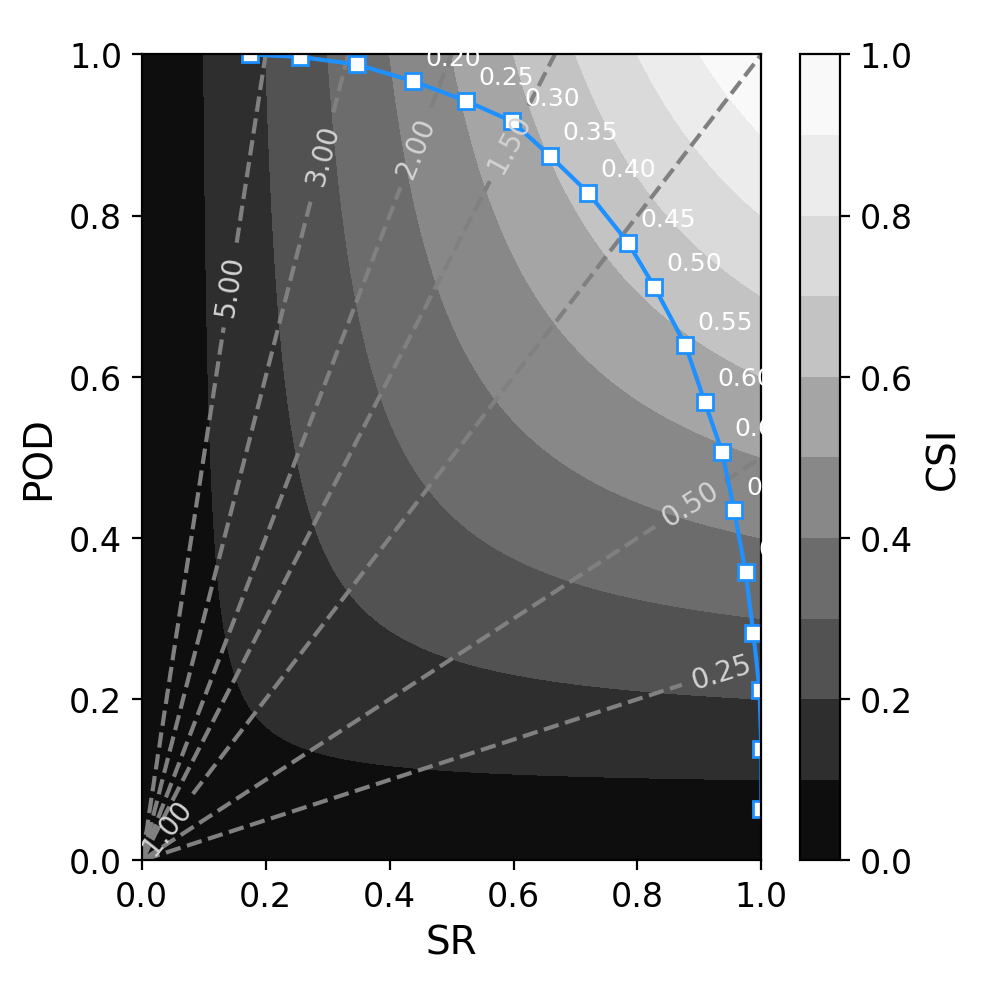

In [44]:
#ravel both
y_v_rav =np.array(val).ravel()
y_preds_rav = np.array(results).ravel()

#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(y_v_rav,y_preds_rav)
fps = fp(y_v_rav,y_preds_rav)
fns = fn(y_v_rav,y_preds_rav)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)


#import some helper functions for our other directory.
import sys
sys.path.insert(1, '/content/WAF_ML_Tutorial_Part2/scripts/')

#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
    ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,fontsize=9,color='white')

plt.tight_layout();

In [45]:
cutoff = .45

Percent of TS Correctly Detected = 77.0%
Percent of noTS Correctly Detected = 96.0%
Binary Accuracy = 94.0%
number of true positives (actual): 1602
number of true negatives (actual): 9348


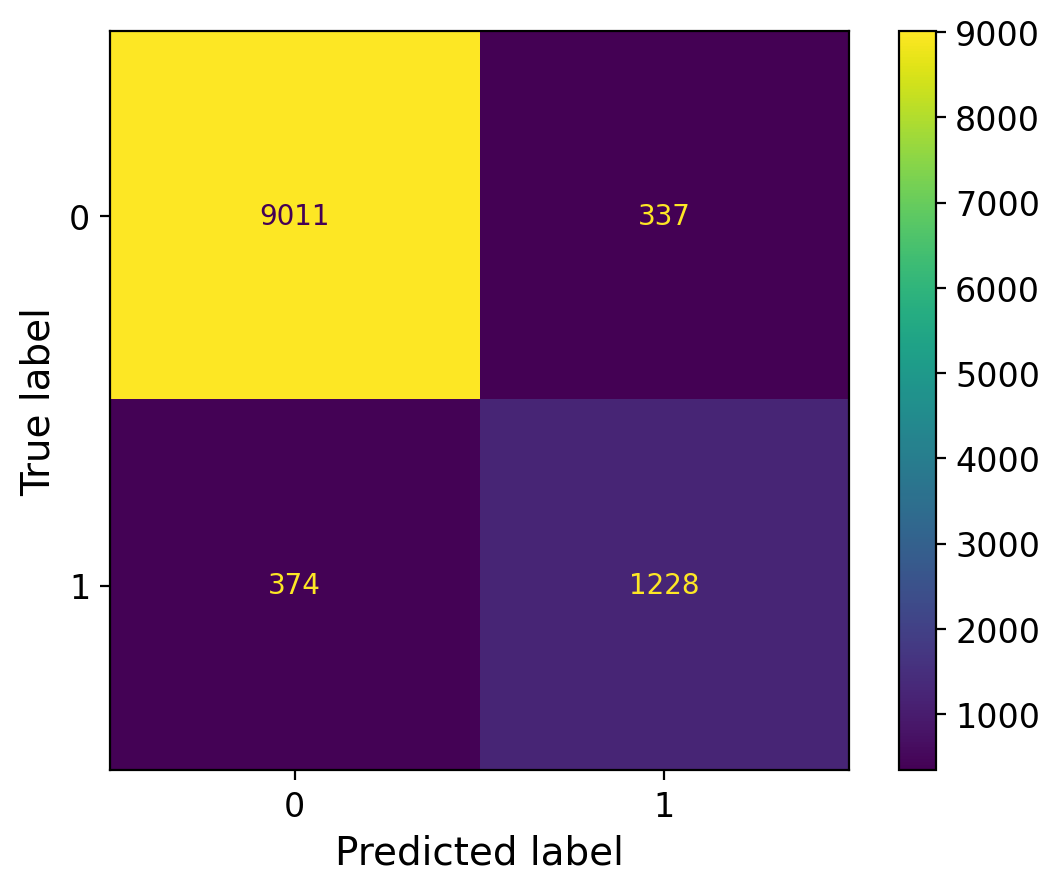

In [47]:
predict = np.array(np.where(results>=cutoff,1,0))
#the contingency table calculator expects y_true,y_pred
cont_table = get_contingency_table(np.array(val),np.array(predict))

accuracy = get_acc(cont_table)
print('Percent of TS Correctly Detected = {}%'.format(np.round(cont_table['num_true_positives']/np.sum(np.array(val))*100,0)))
print('Percent of noTS Correctly Detected = {}%'.format(np.round(cont_table['num_true_negatives']/np.sum(np.where(np.array(val) ==0,1,0))*100,0)))
print('Binary Accuracy = {}%'.format(np.round(accuracy,0)))

# print(cont_table)
print('number of true positives (actual): ' +str(np.sum(np.array(val))))
print('number of true negatives (actual): ' +str(np.sum(np.where(np.array(val) ==0,1,0))))
ConfusionMatrixDisplay(confusion_matrix(np.array(val).ravel(), predict.ravel())).plot();




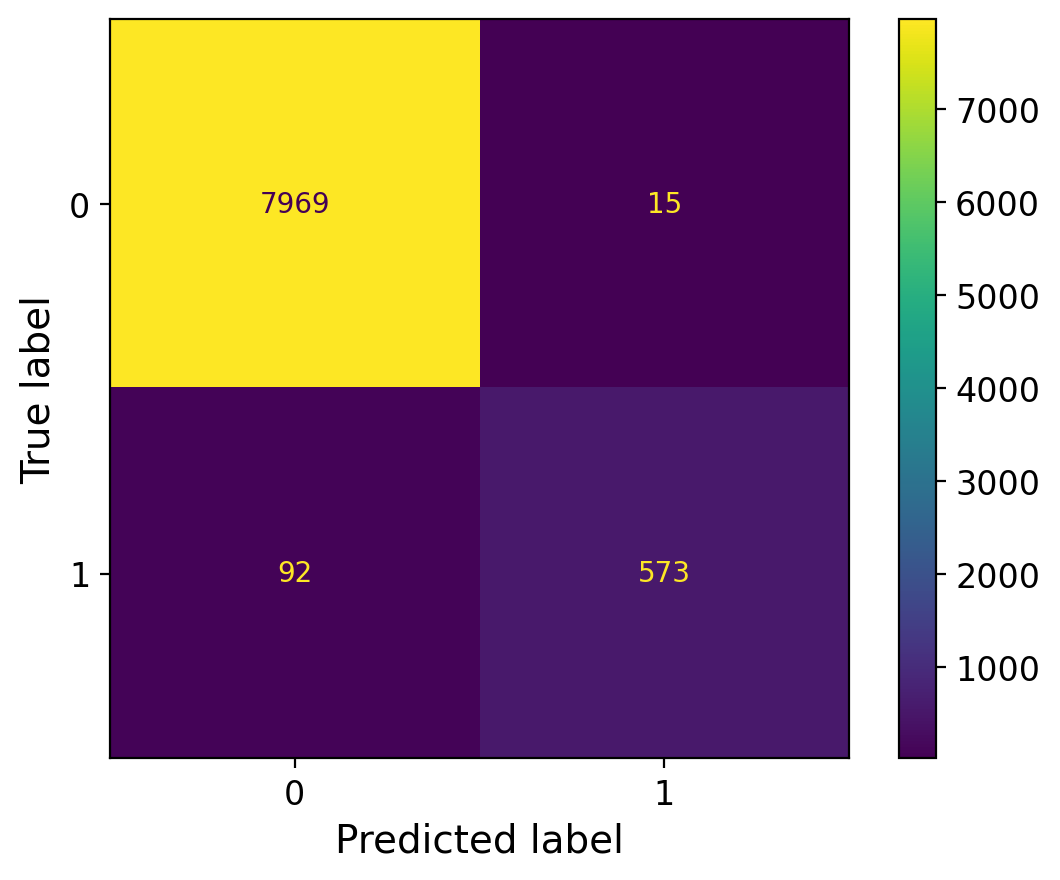

In [48]:
## Confident Results
confidence = .25
conf_id = np.where((np.array(results).ravel()<=confidence) | (np.array(results).ravel()>=1-confidence))[0]
conf_results = np.array(results).ravel()[conf_id] 
conf_results = np.where(conf_results>=cutoff,1,0)
conf_val = np.array(val).ravel()[conf_id]

ConfusionMatrixDisplay(confusion_matrix(conf_val, conf_results)).plot()


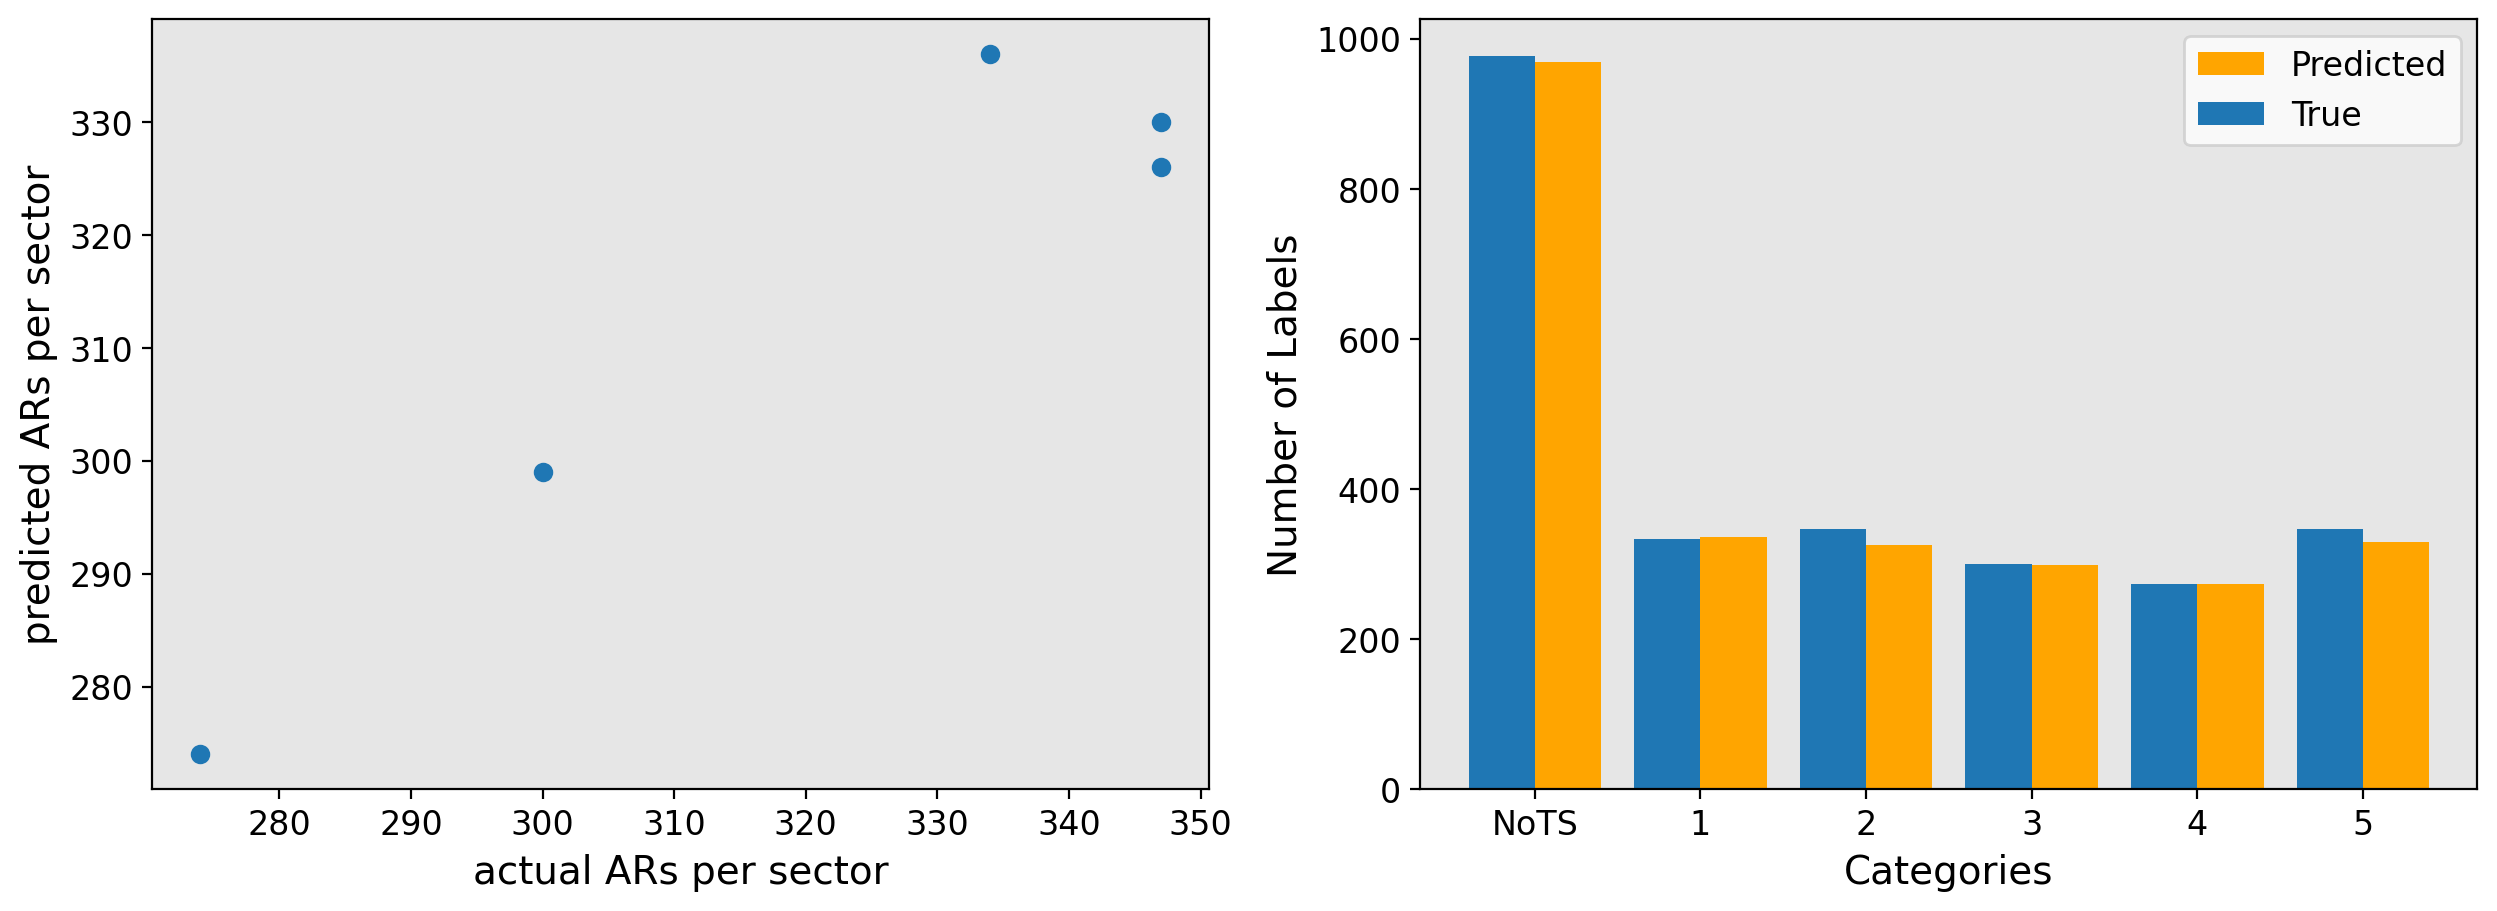

In [49]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].scatter(np.sum(val,0), np.sum(np.array(predict),0))
ax[0].set_ylabel('predicted ARs per sector')
ax[0].set_xlabel('actual ARs per sector')

ax[1].bar(np.arange(0,6)+.2, np.append(np.sum(np.where(np.sum(predict,1)>0,0,1)),np.sum(np.array(predict), axis = 0))
          , width= .4,  color = 'orange', label = 'Predicted')
ax[1].bar(np.arange(0,6)-.4, np.append(np.sum(np.where(np.sum(val,1)>0,0,1)),np.sum(np.array(val), axis = 0))
          , width =.4, align = 'edge', label = 'True')

ax[1].set_ylabel('Number of Labels')
ax[1].set_xlabel('Categories')
ax[1].set_xticks(np.arange(0,6,1))
ax[1].set_xticklabels(['NoTS','1','2','3','4','5'])# '11','12','13','14','15','16','17','18','19','20'])
ax[1].legend()


### Check out one timestep

In [13]:
print('more than one region with TS:')
np.where(np.sum(np.array(val),1)>1)[0]

more than one region with TS:


array([  27,   32,   33,   55,   56,   57,   58,   59,   63,   65,   84,
         85,   90,   92,   93,   94,   95,  107,  108,  130,  132,  133,
        142,  148,  157,  158,  162,  192,  195,  198,  199,  200,  235,
        239,  253,  254,  255,  256,  257,  261,  268,  269,  271,  272,
        275,  282,  283,  295,  300,  301,  318,  330,  335,  336,  360,
        361,  367,  377,  393,  395,  400,  420,  437,  445,  450,  451,
        461,  464,  465,  475,  476,  479,  480,  487,  496,  497,  498,
        500,  517,  524,  528,  532,  533,  548,  550,  555,  556,  561,
        562,  575,  582,  588,  589,  608,  614,  615,  616,  621,  625,
        630,  684,  685,  687,  688,  689,  706,  709,  735,  740,  741,
        769,  778,  780,  782,  783,  784,  785,  786,  787,  788,  789,
        798,  819,  820,  821,  823,  835,  862,  870,  871,  872,  874,
        881,  882,  890,  891,  892,  908,  909,  910,  911,  913,  914,
        915,  916,  929,  934,  941,  942,  951,  9

/tmp/ipykernel_3400298/3584421625.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.bar(true_val,results.iloc[t][true_val], color = 'orange')


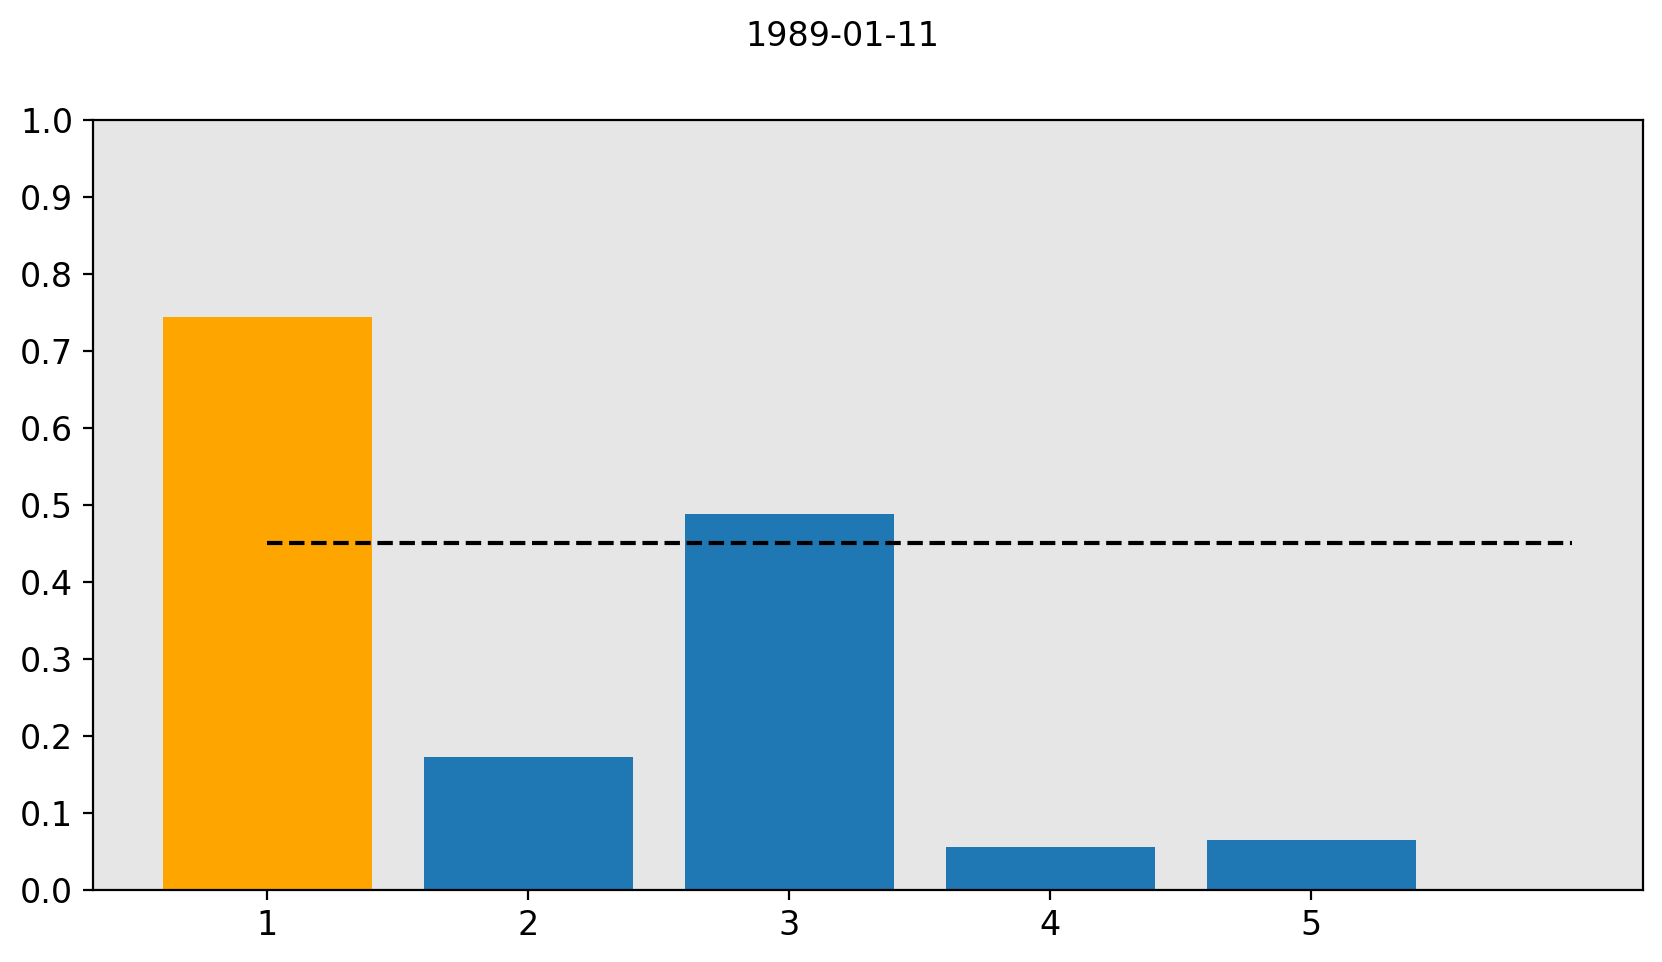

In [14]:
t = 10
time = results.index[t]

true_val = val[val.index ==results.index[t]]
true_val = np.array(true_val.columns[true_val.isin([1]).any()], int)

fig, ax = plt.subplots(1,1,figsize=(10, 5))
fig.suptitle(time[0:13])


ax.bar(np.arange(0,5,1),results.iloc[t])
ax.bar(true_val,results.iloc[t][true_val], color = 'orange')
ax.set_xticks(np.arange(0,5,1), ['1','2','3','4','5'])#,'11',x'12','13','14','15','16','17','18','19','20']);
ax.hlines(cutoff, xmin = 0, xmax = 5, linestyles='--', color = 'black')
ax.set_yticks(np.arange(0,1.1,.1));


### Check out one category

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


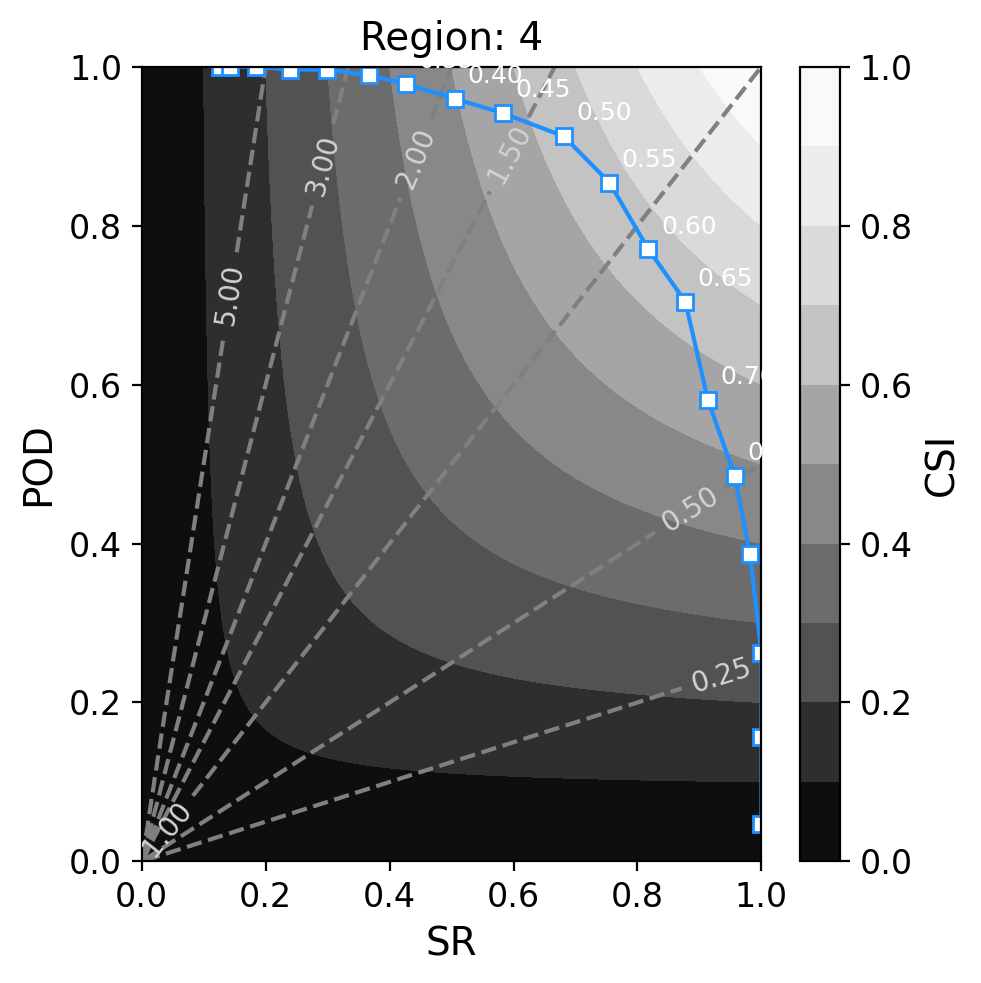

In [55]:
c =3

y_v_rav =np.array(val[[str(c)]]).ravel()
y_preds_rav = np.array(results[[str(c)]]).ravel()

#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(y_v_rav,y_preds_rav)
fps = fp(y_v_rav,y_preds_rav)
fns = fn(y_v_rav,y_preds_rav)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)


#import some helper functions for our other directory.
import sys
sys.path.insert(1, '/content/WAF_ML_Tutorial_Part2/scripts/')

#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
    ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,fontsize=9,color='white')

ax.set_title('Region: '+str(c+1))
plt.tight_layout();

In [4]:
test = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/example_ds_train.nc').isel(time = slice(0,2000))

In [5]:
Y_test = test.labels.load()

In [6]:
pos = np.array(Y_test).sum()
neg = np.where(np.array(Y_test)==1,0,1).sum()
initial_bias = np.log([pos/neg])


In [7]:
initial_bias

array([-1.85659865])

In [8]:
tf.keras.initializers.constant(initial_bias)

In [3]:
from functions import testing_parameters, cnn_model
testing_parameters()

[(2, 32, 2, 32, 60),
 (2, 32, 2, 32, 30),
 (2, 32, 2, 64, 60),
 (2, 32, 2, 64, 30),
 (2, 32, 3, 32, 60),
 (2, 32, 3, 32, 30),
 (2, 32, 3, 64, 60),
 (2, 32, 3, 64, 30),
 (2, 32, 4, 32, 60),
 (2, 32, 4, 32, 30),
 (2, 32, 4, 64, 60),
 (2, 32, 4, 64, 30),
 (2, 64, 2, 32, 60),
 (2, 64, 2, 32, 30),
 (2, 64, 2, 64, 60),
 (2, 64, 2, 64, 30),
 (2, 64, 3, 32, 60),
 (2, 64, 3, 32, 30),
 (2, 64, 3, 64, 60),
 (2, 64, 3, 64, 30),
 (2, 64, 4, 32, 60),
 (2, 64, 4, 32, 30),
 (2, 64, 4, 64, 60),
 (2, 64, 4, 64, 30),
 (3, 32, 2, 32, 60),
 (3, 32, 2, 32, 30),
 (3, 32, 2, 64, 60),
 (3, 32, 2, 64, 30),
 (3, 32, 3, 32, 60),
 (3, 32, 3, 32, 30),
 (3, 32, 3, 64, 60),
 (3, 32, 3, 64, 30),
 (3, 32, 4, 32, 60),
 (3, 32, 4, 32, 30),
 (3, 32, 4, 64, 60),
 (3, 32, 4, 64, 30),
 (3, 64, 2, 32, 60),
 (3, 64, 2, 32, 30),
 (3, 64, 2, 64, 60),
 (3, 64, 2, 64, 30),
 (3, 64, 3, 32, 60),
 (3, 64, 3, 32, 30),
 (3, 64, 3, 64, 60),
 (3, 64, 3, 64, 30),
 (3, 64, 4, 32, 60),
 (3, 64, 4, 32, 30),
 (3, 64, 4, 64, 60),
 (3, 64, 4, 6

In [9]:
test.features.shape[1:]

(81, 576, 5)

In [3]:
cnn_model

<function functions.cnn_model(parameter_select, input_shape, name)>

In [10]:
model  = cnn_model(parameter_select = testing_parameters()[12], 
                   input_shape = test.features.shape[1:], 
                   name = 'test',
                   output_bias = initial_bias
                  )


TypeError: cnn_model() got an unexpected keyword argument 'output_bias'

In [7]:
testing_parameters()[12]

(2, 64, 2, 32, 60)

In [9]:
import numpy as np
import itertools
Num_con_layers = [2, 3]
Num_con_filters = [64]

Num_dense_layers = [2,3]
Num_dense_filters = [64]

Batch_size = [60, 30]
Learning_rate = [1e-2, 1e-6]

options = [ Num_con_layers, Num_con_filters, Num_dense_layers, Num_dense_filters,  Batch_size, Learning_rate]

list(itertools.product(*options))

[(2, 64, 2, 64, 60, 0.01),
 (2, 64, 2, 64, 60, 1e-06),
 (2, 64, 2, 64, 30, 0.01),
 (2, 64, 2, 64, 30, 1e-06),
 (2, 64, 3, 64, 60, 0.01),
 (2, 64, 3, 64, 60, 1e-06),
 (2, 64, 3, 64, 30, 0.01),
 (2, 64, 3, 64, 30, 1e-06),
 (3, 64, 2, 64, 60, 0.01),
 (3, 64, 2, 64, 60, 1e-06),
 (3, 64, 2, 64, 30, 0.01),
 (3, 64, 2, 64, 30, 1e-06),
 (3, 64, 3, 64, 60, 0.01),
 (3, 64, 3, 64, 60, 1e-06),
 (3, 64, 3, 64, 30, 0.01),
 (3, 64, 3, 64, 30, 1e-06)]

In [51]:
link_file='/projects/reba1583/data_links.txt'
lines_1 = np.loadtxt(link_file, dtype=str, unpack=False)
#find lines with year from system argument
lines = [l for l in lines_1 if str(year) in l[108:112]]
len(lines_1)

2983

In [45]:
year = '2015'
link_file='/projects/reba1583/data_links.txt'
lines_1 = np.loadtxt(link_file, dtype=str, unpack=False)
#find lines with year from system argument
lines = [l for l in lines_1 if str(year) in l[123:131]]
len(lines_1)

2983

In [52]:
lines_1[10][123:131]

'20150110'

In [47]:
line_link = lines[40]

In [36]:
line_link

'https://opendap.earthdata.nasa.gov/collections/C1276812863-GES_DISC/granules/M2T1NXSLV.5.12.4%3AMERRA2_400.tavg1_2d_slv_Nx.20150111.nc4.dap.nc4?dap4.ce=/T2M%5B0:23%5D%5B28:32%5D%5B118:120%5D;/time;/lat%5B28:32%5D;/lon%5B118:120%5D'

In [27]:
import glob

In [50]:
len(glob.glob('/pl/active/ATOC_SynopticMet/data/ar_data/MichelleData/'+'20150912'+'.nc'))



0